## Import Modules

In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras_preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [39]:
##BASE_DIR = r"C:\Users\sagar\OneDrive\Desktop\Emotion_Detection_CNN-main\data"

In [40]:
BASE_DIR = r"D:\BE COMP\Deep Learning\crop_part1"

In [41]:
images = []
ages = []
genders = []

for i in os.listdir(BASE_DIR)[0:8000]:
    image_path = os.path.join(BASE_DIR, filename)
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(image_path)

In [42]:
image_paths = pd.Series(list(image_paths), name = 'image')
age_labels = pd.Series(list(age_labels), name = 'age')
gender_labels = pd.Series(list(gender_labels), name = 'gender')

df = pd.concat([image_paths, age_labels, gender_labels], axis=1)
df

,image,age,gender
0,D:\BE COMP\Deep Learning\crop_part1\100_1_0_20...,100,1
1,D:\BE COMP\Deep Learning\crop_part1\100_1_2_20...,100,1
2,D:\BE COMP\Deep Learning\crop_part1\101_1_2_20...,101,1
3,D:\BE COMP\Deep Learning\crop_part1\10_0_0_201...,10,0
4,D:\BE COMP\Deep Learning\crop_part1\10_0_0_201...,10,0
...,...,...,...
9775,D:\BE COMP\Deep Learning\crop_part1\9_1_3_2016...,9,1
9776,D:\BE COMP\Deep Learning\crop_part1\9_1_3_2017...,9,1
9777,D:\BE COMP\Deep Learning\crop_part1\9_1_4_2017...,9,1
9778,D:\BE COMP\Deep Learning\crop_part1\9_1_4_2017...,9,1


In [43]:
# convert to dataframe
#df = pd.DataFrame()
#df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
#df.head()

In [44]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

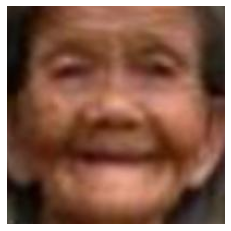

In [45]:
from PIL import Image
img = Image.open(df['image'][1])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

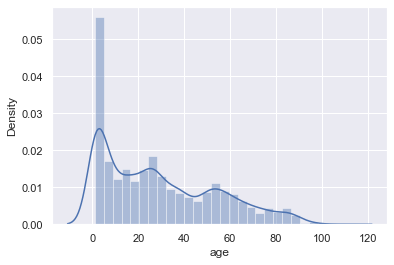

In [46]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

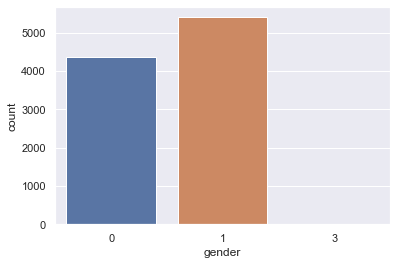

In [47]:
sns.countplot(df['gender'])

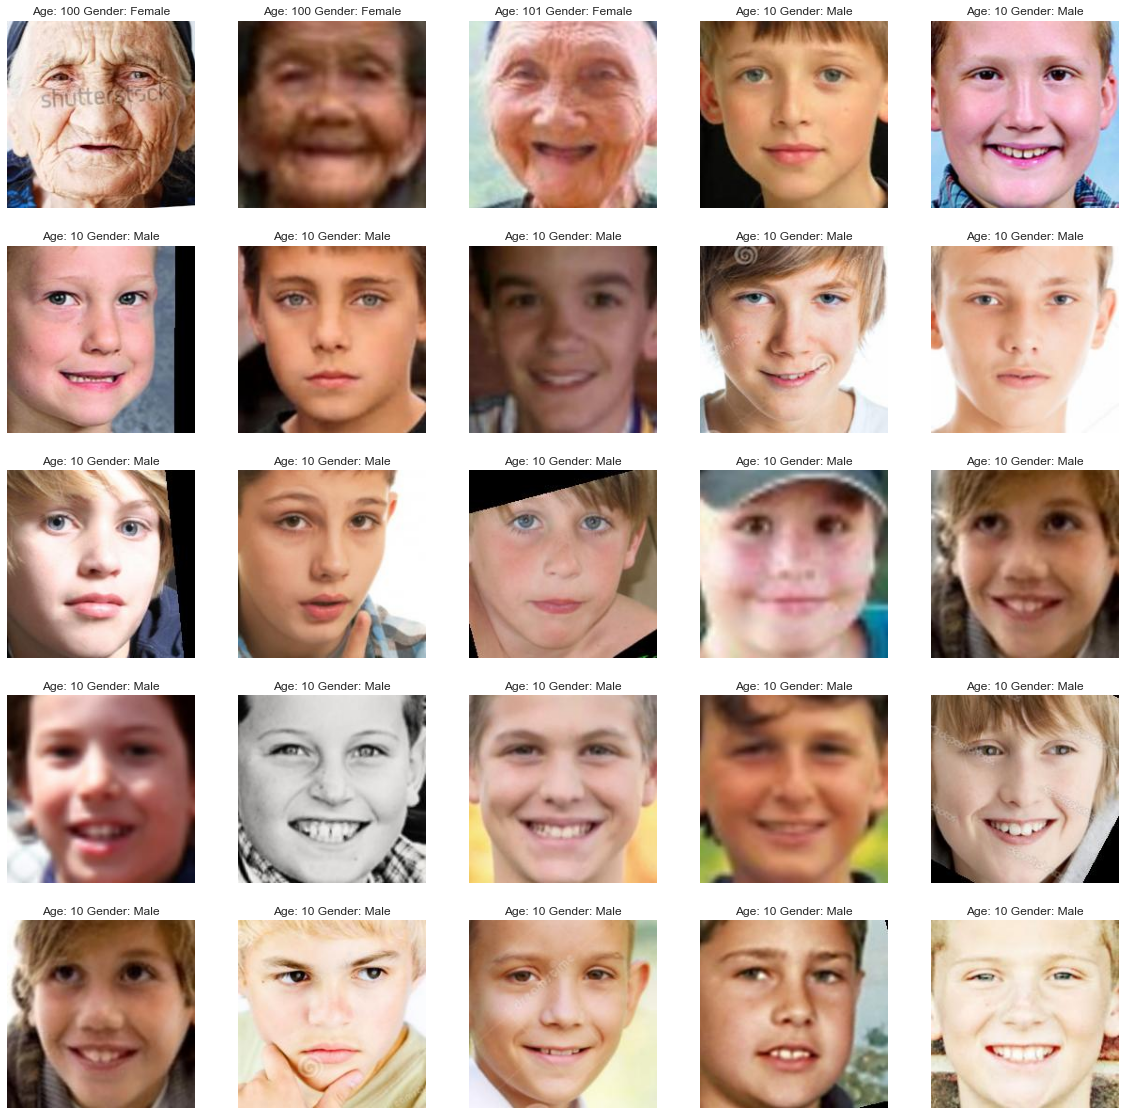

In [48]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

<AxesSubplot:xlabel='age', ylabel='Density'>

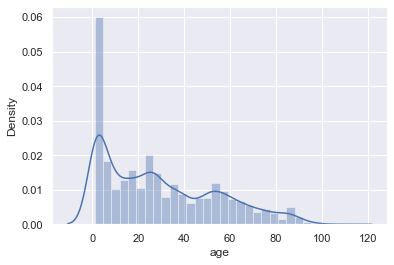

In [49]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [50]:
under4s = []

for i in range(len(df)):
    if df['age'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['age'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

<AxesSubplot:xlabel='age', ylabel='Density'>

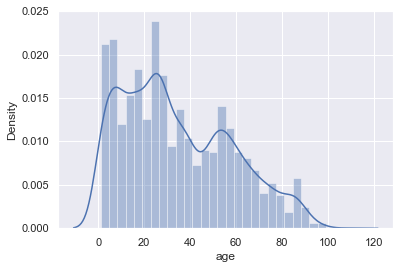

In [51]:
sns.distplot(df['age'],kde=True, bins=30)

In [52]:
df = df[df['age'] < 80]

<AxesSubplot:xlabel='age', ylabel='Density'>

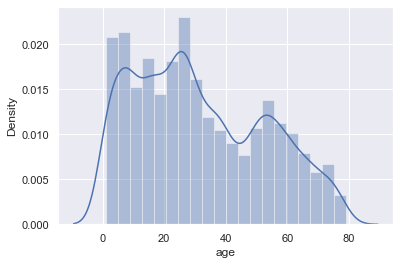

In [53]:
sns.distplot(df['age'],kde=True, bins=20)

<AxesSubplot:xlabel='gender', ylabel='count'>

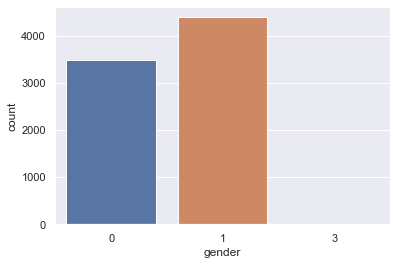

In [54]:
sns.countplot(df['gender'])

<AxesSubplot:xlabel='gender', ylabel='count'>

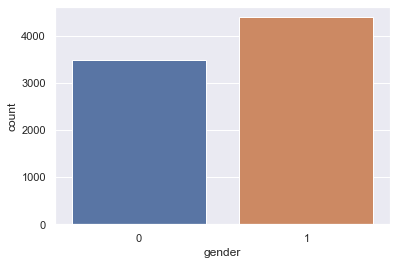

In [55]:
df = df[df['gender'] != 3]
sns.countplot(df['gender'])

In [56]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [57]:
X = extract_features(df['image'])

  0%|          | 0/7870 [00:00<?, ?it/s]

In [58]:
X.shape

(7870, 128, 128, 1)

In [59]:
# normalize the images
X = X/255.0

In [60]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [61]:
from sklearn.model_selection import train_test_split
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2, stratify=y_gender)

In [62]:
input_shape = (128, 128, 1)

## Model Creation

In [63]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

In [31]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
197/197 [==============================] - 81s 398ms/step - loss: 16.7862 - gender_out_loss: 0.6903 - age_out_loss: 16.0959 - gender_out_accuracy: 0.5673 - age_out_accuracy: 0.0000e+00 - val_loss: 31.1419 - val_gender_out_loss: 0.6918 - val_age_out_loss: 30.4502 - val_gender_out_accuracy: 0.5172 - val_age_out_accuracy: 0.2166
Epoch 2/5
197/197 [==============================] - 69s 349ms/step - loss: 14.2568 - gender_out_loss: 0.5672 - age_out_loss: 13.6896 - gender_out_accuracy: 0.7027 - age_out_accuracy: 0.0000e+00 - val_loss: 28.3156 - val_gender_out_loss: 0.6718 - val_age_out_loss: 27.6439 - val_gender_out_accuracy: 0.5870 - val_age_out_accuracy: 0.2166
Epoch 3/5
197/197 [==============================] - 74s 378ms/step - loss: 12.4264 - gender_out_loss: 0.4768 - age_out_loss: 11.9496 - gender_out_accuracy: 0.7700 - age_out_accuracy: 0.0000e+00 - val_loss: 18.7759 - val_gender_out_loss: 0.7112 - val_age_out_loss: 18.0647 - val_gender_out_accuracy: 0.6137 - val_age_out_acc

## Plot the Results

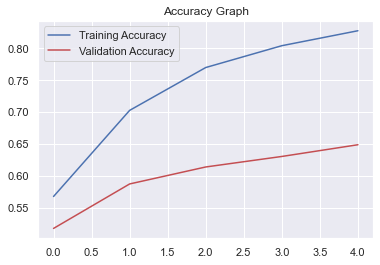

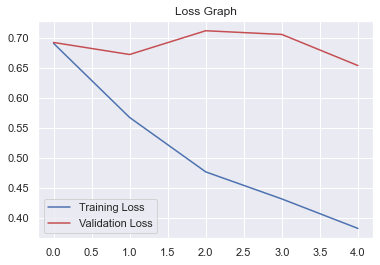

In [32]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

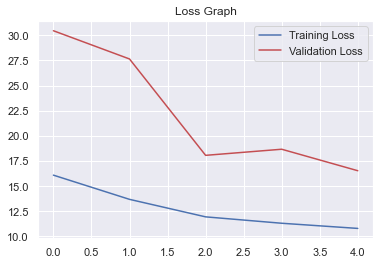

In [33]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Female Original Age: 32
1/1 [==============================] - 0s 243ms/step
Predicted Gender: Female Predicted Age: 36


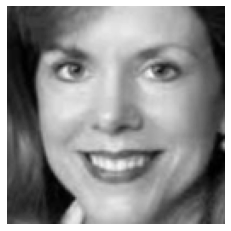

In [34]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 18
1/1 [==============================] - 0s 32ms/step
Predicted Gender: Male Predicted Age: 21


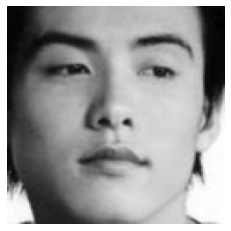

In [36]:
image_index = 1000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 10
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Female Predicted Age: 18


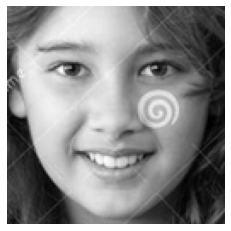

In [37]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');